In [185]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#set paramters N = domain points, T = time evolve, V = viscoscity 
N = 256          
T = 1            
V = 0.01 / np.pi

#Generate Data
def generate_data(nums, N, V, T):
    X = []
    Y = []
    for i in range(nums):
        x = np.linspace(-1, 1, N)
        phase = np.random.uniform(0, 2*np.pi) 
        amp = np.random.uniform(0.5, 1.5)
        u0 = -amp * np.sin(np.pi * x + phase)
        u = np.exp(-V * np.pi**2 * T) * u0
        X.append(u0)
        Y.append(u)
    return np.array(X), np.array(Y)

In [186]:
#Fourier Layer
class FourierLayer(nn.Module):
    def __init__(self, modes, width):
        super(FourierLayer, self).__init__()
        self.modes = modes
        self.width = width
        self.fc1 = nn.Linear(2 * modes, width)
        self.fc2 = nn.Linear(width, 2 * modes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x_ft = torch.fft.rfft(x)
        x_ft = x_ft[..., :self.modes]
        x_ft = torch.cat([x_ft.real, x_ft.imag], dim=-1)
        x_ft = self.fc1(x_ft)
        x_ft = self.relu(x_ft)
        x_ft = self.fc2(x_ft)
        x_ft = torch.complex(x_ft[..., :self.modes], x_ft[..., self.modes:])
        x = torch.fft.irfft(x_ft, n=x.size(-1))
        return x

In [187]:
#FNO
class FNO(nn.Module):
    def __init__(self, modes, width):
        super(FNO, self).__init__()
        self.layer1 = FourierLayer(modes, width)
        self.layer2 = FourierLayer(modes, width)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        return x

In [188]:
#Generate data
X, Y = generate_data(1000, N, V, T)
xTensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
yTensor = torch.tensor(Y, dtype=torch.float32).unsqueeze(1)

#Split data
num_train = int(0.8 * len(xTensor))
X_train, Y_train = xTensor[:num_train], yTensor[:num_train]
X_test, Y_test = xTensor[num_train:], yTensor[num_train:]

#MSE LOSS
model = FNO(modes=16, width=64)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) #adam optimzer lr=0.001


def train(model, criterion, optimizer, X_train, Y_train, epochs=100):
    model.train()
    lossVal = []
    start_time = time.time() 
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, Y_train)
        loss.backward()
        optimizer.step()
        lossVal.append(loss.item())
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    end_time = time.time()
    total_time = end_time - start_time
    print(f"Training completed in: {total_time:.2f} seconds")
    return lossVal

lossVal = train(model, criterion, optimizer, X_train, Y_train)


def test(model, X_test, Y_test):
    model.eval()
    with torch.no_grad():
        pred = model(X_test)
        loss = criterion(pred, Y_test)
    Y_test_np = Y_test.squeeze().numpy()
    predict_np = pred.squeeze().detach().numpy()
    mse = mean_squared_error(Y_test_np, predict_np)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(Y_test_np, predict_np)
    r2 = r2_score(Y_test_np, predict_np)

    print(f"Test Loss: {loss.item()}")
    print(f"MSE: {mse}")
    print(f"RMSE : {rmse}")
    print(f"MAE: {mae}")
    print(f"R^2: {r2}")

    return pred, mse, rmse, mae, r2
pred, mse, rmse, mae, r2 = test(model, X_test, Y_test)



Epoch 0, Loss: 0.5046389698982239
Epoch 10, Loss: 0.46120768785476685
Epoch 20, Loss: 0.40091076493263245
Epoch 30, Loss: 0.29848068952560425
Epoch 40, Loss: 0.15693756937980652
Epoch 50, Loss: 0.03873220086097717
Epoch 60, Loss: 0.011401710100471973
Epoch 70, Loss: 0.005679996218532324
Epoch 80, Loss: 0.00136424764059484
Epoch 90, Loss: 0.0013860539766028523
Training completed in: 0.66 seconds
Test Loss: 0.0005484528373926878
MSE: 0.0005484528373926878
RMSE : 0.02341906912624836
MAE: 0.017872799187898636
R^2: 0.998852387731846


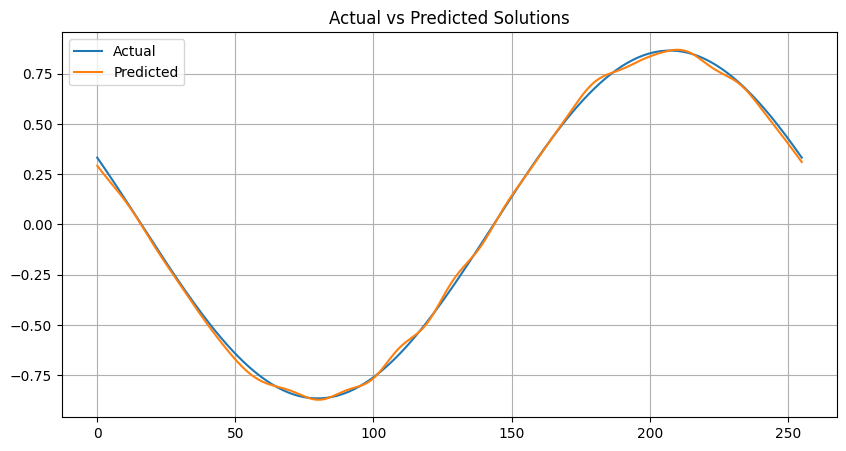

In [189]:
def plot_results(Y_test, pred):
    plt.figure(figsize=(10, 5))
    plt.plot(Y_test[0][0], label='Actual')
    plt.plot(pred[0][0], label='Predicted')
    plt.legend()
    plt.title('Actual vs Predicted Solutions')
    plt.grid(True) 
    plt.show()
plot_results(Y_test, pred)

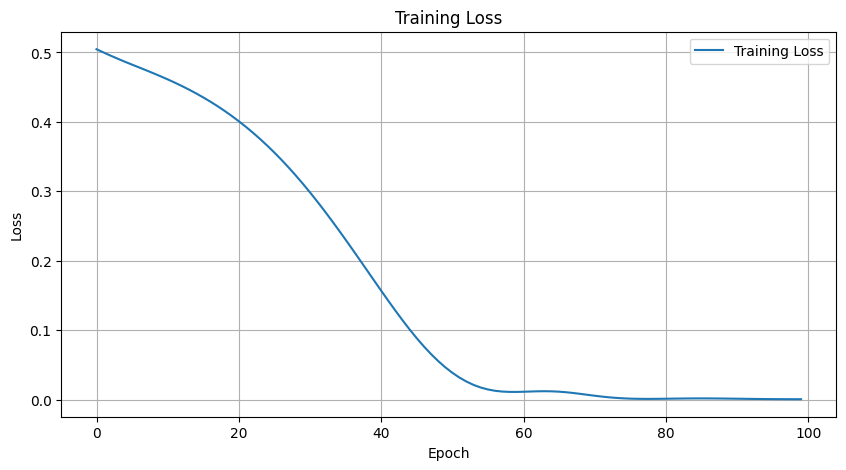

In [190]:
def plot_loss(lossVal):
    plt.figure(figsize=(10, 5))
    plt.plot(lossVal, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
plot_loss(lossVal)